# Interactive Viz - load dataset

After the usually library imports, we load the P3 dataset. We remark that, because of problems in reading the csv file, we have converted the original .csv dataset as an excel spreadsheet.

In [1]:
import pandas as pd

In [2]:
# load excel spreadsheet
data = pd.read_excel('P3.xlsx')
data = data.set_index('Project Number')
#data.head(5)

We check if the project number is actually a unique identifier, as declared in the SNSF P3 website.

In [3]:
data.index.is_unique

True

Since it is unique, we set it as the index of the dataframe. We explore now the dataframe parameters, in order to understand which of them are interesting for our purposes:

In [4]:
data.columns

Index(['Project Title', 'Project Title English', 'Responsible Applicant',
       'Funding Instrument', 'Funding Instrument Hierarchy', 'Institution',
       'University', 'Discipline Number', 'Discipline Name',
       'Discipline Name Hierarchy', 'Start Date', 'End Date',
       'Approved Amount', 'Keywords'],
      dtype='object')

A complete description of the parameters can be found at http://p3.snf.ch/Pages/DataAndDocumentation.aspx. The attributes which are interesting for us are:
+ '**University**': academic insitution where the project is carried out
+ '**Approved Amount**': grant for the project (CHF)

We keep in also the '**Start Date**' and the '**End date**' parameters for eventual further investigations which take time into account.

Let us filter the dataset, save its reduced version as an .xlsx file.

In [7]:
data_red = data[['University','Approved Amount','Start Date','End Date']]
data_red.head(5)

,University,Approved Amount,Start Date,End Date
Project Number,,,,
1,Nicht zuteilbar - NA,11619.00,01.10.1975,30.09.1976
4,Université de Genève - GE,41022.00,01.10.1975,30.09.1976
5,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.00,01.03.1976,28.02.1985
6,Universität Basel - BS,52627.00,01.10.1975,30.09.1976
7,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.00,01.01.1976,30.04.1978


In [8]:
data_red.to_excel('Grants.xlsx',sheet_name='Sheet1')

From now on, we will work on the reduced dataset, which is lighter to load and read. You can start directly from the following section.

# Preliminar data exploration

In this section we will explore the essential features of the dataset.

In [146]:
import pandas as pd
import numpy as np
import seaborn as sbr
import matplotlib.pyplot as plt
%matplotlib inline

We know *a priori* the structure of the dataset, and in particular have experienced that some University fields are filled with NaN, while other rows contain some specification string, such as for instance "*Nicht zuteilbar - NA*", that is, 'not allocable'. Moreover, when the grant amount is not given, one can find the specification "*data not included in P3*". These  data arise actually from projects developed at foreign Universities, so that they are not interesting. It is then reasonable to drop them out of the dataset.

In [110]:
data = pd.read_excel('Grants.xlsx',sheet_name='Sheet1',na_values=['Nicht zuteilbar - NA','data not included in P3','NaN'])
data = data.set_index('Project Number')
data.head(3)

,University,Approved Amount,Start Date,End Date
Project Number,,,,
1,NaN,11619.0,01.10.1975,30.09.1976
4,Université de Genève - GE,41022.0,01.10.1975,30.09.1976
5,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0,01.03.1976,28.02.1985


We convert the grant amounts from string to floating point numbers, in order to treat them quantitatively.

In [111]:
data['Approved Amount']=data['Approved Amount'].astype(float)

In [116]:
# University
nans = data['University'].isnull().value_counts()
print(str(nans[True]/nans.sum())+' Nans ratio out of '+str(nans.sum())+' projects')

0.243492941894 Nans ratio out of 63969 projects


There are roughly **24%** of NaN values in the field '**University**', that is, almost 1/4 of the projects are developed in non Swiss Universities.

In [115]:
# Grants
nans = data['Approved Amount'].isnull().value_counts()
print(str(nans[True]/nans.sum())+' Nans ratio out of '+str(nans.sum())+' projects')

0.170551360815 Nans ratio out of 63969 projects


The percentage of invalid grants data is about **17%**.

We will now convert the date fields from strings into datetime format, in order to better process them and link the grants to their temporal evolution.

In [156]:
from datetime import datetime
data['Start Date'] = pd.to_datetime(data['Start Date'], format="'%d.%m.%y'",errors='ignore')
data['End Date'] = pd.to_datetime(data['End Date'], format="'%d.%m.%y'",errors='ignore')

In [157]:
data['Start Date'].isnull().value_counts()

False    63968
True         1
Name: Start Date, dtype: int64

Notice that there is one NaN value in the data field (Project Number: 35737). We do not want to wipe it out, since there are informations concerning both the grant and the University.

Now we drop the NaNs out of the dataset and visualize the resulting distribution of grants in time:

In [164]:
data_red = data.dropna(subset=['University','Approved Amount'])

In [169]:
print('Percentage of removed data: ' + str(1-len(data_red)/len(data)) )

Percentage of removed data: 0.24521252481670808


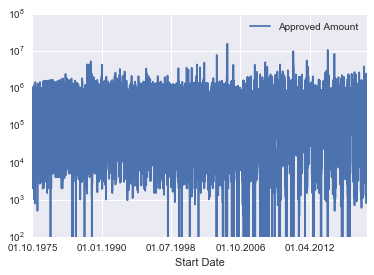

In [194]:
# plot the data in logarithmic scale and the statistical distribution
data_red.plot(x='Start Date',y='Approved Amount',logy=1)

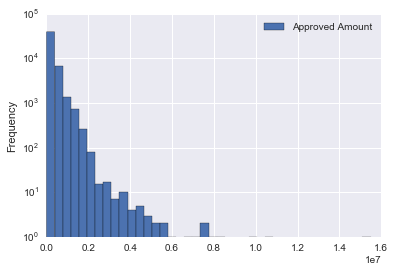

In [221]:
data_red.plot(x='Start Date',y='Approved Amount',kind='hist',logy=True,bins=40)

The distribution of the dataset seems not to follow a power law, since the general behaviour is non linear, or it could be only for law values of grants, because of a heavy tail at high values. We save now the reduced dataset for the real purpose of this analysis, which is to build a clorophlet map using this information.

In [223]:
data_red.to_excel('P3.xlsx')

# Outliers identification

We want now to identify the outlier points in the grants amount distribution.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import seaborn
from datetime import datetime

In [34]:
data = pd.read_excel('P3.xlsx')
# set the identifier of the project as the index
data = data.set_index('Project Number')
data.head(3)

,University,Approved Amount,Start Date,End Date
Project Number,,,,
4,Université de Genève - GE,41022.0,01.10.1975,30.09.1976
5,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0,01.03.1976,28.02.1985
6,Universität Basel - BS,52627.0,01.10.1975,30.09.1976


Our hypothesis concerning the outliers of the distribution is that the more granted the project is, the longer it takes to be carried out. We add a column to the dataset to specify the duration of the project, using the datetime format.

In [35]:
dates = []
for l in data.index:
    dates.append( pd.to_datetime(data['End Date'][l])-pd.to_datetime(data['Start Date'][l]) )

data['Duration']=dates
data.head(3)

,University,Approved Amount,Start Date,End Date,Duration
Project Number,,,,,
4,Université de Genève - GE,41022.0,01.10.1975,30.09.1976,629 days
5,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0,01.03.1976,28.02.1985,3344 days
6,Universität Basel - BS,52627.0,01.10.1975,30.09.1976,629 days


In [36]:
# convert days to int numbers in order to plot them
duration = []
for l in data.index:
    if(pd.isnull(data['Duration'][l])):
        duration.append('NaN')
    else:
        duration.append(data['Duration'][l].days)
        
data['Duration']=duration
data.head(3)

,University,Approved Amount,Start Date,End Date,Duration
Project Number,,,,,
4,Université de Genève - GE,41022.0,01.10.1975,30.09.1976,629
5,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0,01.03.1976,28.02.1985,3344
6,Universität Basel - BS,52627.0,01.10.1975,30.09.1976,629


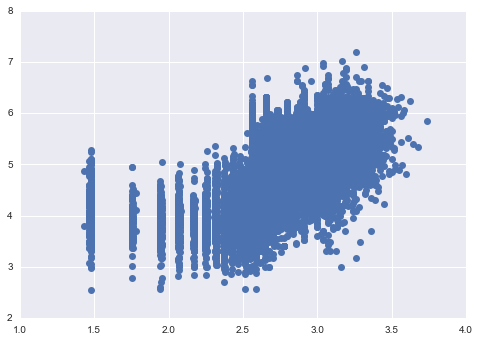

In [47]:
# scatter plot in log-log scale
plt.pyplot.plot(data['Duration'].astype(float).apply(np.log10),data['Approved Amount'].apply(np.log10),'o')

Our hypothesis seems to be confirmed. Grants and duration are positively correlated, so that highly granted projects do not represent "bad" outliers, but are linked to longer projects.

# From University to Canton

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import seaborn
from datetime import datetime

data = pd.read_excel('P3.xlsx')
# set the identifier of the project as the index
data = data.set_index('Project Number')
data.head(3)

,University,Approved Amount,Start Date,End Date
Project Number,,,,
4,Université de Genève - GE,41022.0,01.10.1975,30.09.1976
5,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0,01.03.1976,28.02.1985
6,Universität Basel - BS,52627.0,01.10.1975,30.09.1976


We select al the universities appearing in the dataset without repetitions:

In [2]:
universities = data.University.unique()

We retrieve now the list of Swiss cantons scraping it from the web at the following address: 'http://swiss-government-politics.all-about-switzerland.info/swiss-federal-states-cantons.html'

In [3]:
import requests
url = 'http://swiss-government-politics.all-about-switzerland.info/swiss-federal-states-cantons.html'
r = requests.get(url)
cantons = pd.read_html(r.text)
cantons = cantons[3]
cantons.columns = cantons.loc[0]
cantons = cantons.drop(0,axis=0)
cantons = cantons[['Name of Canton', 'Abbr','Capital']]
cantons = cantons.drop(27,axis=0)
cantons.columns = ['Canton','Abbr','Capital']

# cleaning names
cantons.loc[7]['Canton']='Fribourg'
cantons.loc[8]['Canton']='Genève'
cantons.loc[10]['Canton']='Graubünden'
cantons.loc[12]['Canton']='Luzern'
cantons.loc[24]['Canton']='Valais'

cantons.loc[5]['Capital']='Basel'
cantons.loc[6]['Capital']='Bern'
cantons.loc[7]['Capital']='Fribourg'
cantons.loc[8]['Capital']='Genève'
cantons.loc[12]['Capital']='Luzern'
cantons.loc[23]['Capital']='Lausanne'
cantons.loc[24]['Capital']='Sion'
cantons.loc[26]['Capital']='Zürich'

In [4]:
cantons

,Canton,Abbr,Capital
1,Aargau,AG,Aarau
2,Appenzell Ausserrhoden,AR,Herisau
3,Appenzell Innerrhoden,AI,Appenzell
4,Basel-Land,BL,Liestal
5,Basel-Stadt,BS,Basel
6,Bern,BE,Bern
7,Fribourg,FR,Fribourg
8,Genève,GE,Genève
9,Glarus,GL,Glarus
10,Graubünden,GR,Chur


Now we must collect the geographical information of each university, mapping it onto its own Canton. If this operation is not possible, as it happens with private or no profit organizations, we will consider the entry as invalid ('NaN'), which will make our future analysis faster. We divide our research in several steps, trying to link by Capital city and then by Canton name, looking for occurrencies in the list of universities. Thereafter, we select the not yet mapped objects and try to assign them manually.

By Capital:

In [5]:
# try to link universities to Cantons' capitals
mapping = {}
mapped = []
for city in cantons.Capital:
    for uni in universities:
        if city in uni:
            mapping[uni]=city
            mapped.append(uni)
            
#MAPPING is the main dictionary; it links university string with Canton name abbreviation
            
MAPPING = {}
for k in mapped:
    index = cantons[cantons.Capital==mapping[k]].index[0]
    MAPPING[k] = cantons.Abbr[index]

Other entities:

In [6]:
# define the public or private entities which cannot be mapped onto any Canton

mapped2 = []
privat = ['NPO (Biblioth., Museen, Verwalt.) - NPO','Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL',
          'Weitere Institute - FINST','Firmen/Privatwirtschaft - FP', 'Weitere Spitäler - ASPIT']
for firm in privat:
    for uni in universities:
        if uni==firm:
            mapping[firm]='other'
            mapped2.append(firm)
for k in mapped2:
    MAPPING[k] = 'other'

In [7]:
# not yet mapped objects: still to be processed
remainder = []
for uni in universities:
    flag = False
    for m in mapped+mapped2:
        if uni==m:
            flag = True
    if flag==False:
        remainder.append(uni)

By Canton name:

In [8]:
# search by Canton name and link Canton name with its abbreviation
mapping2 = {}
mapped3 = []
for canton in cantons.Canton:
    for uni in remainder:
        if canton in uni:
            mapping2[uni]=canton
            mapped3.append(uni)

for k in mapped3:
    index = cantons[cantons.Canton==mapping2[k]].index[0]
    MAPPING[k] = cantons.Abbr[index]

Not yet defined entities:

In [9]:
# not yet mapped objects
remainder2 = []
for uni in remainder:
    flag = False
    for m in mapped3:
        if uni==m:
            flag = True
    if flag==False:
        remainder2.append(uni)
        
for k in remainder2:
    MAPPING[k] = 'not defined'

Proceed by manual mapping for the most recurrent Insitutions:

In [23]:
MAPPING['Università della Svizzera italiana - USI']='TI'
MAPPING['Inst. de Hautes Etudes Internat. et du Dév - IHEID']='GE'
MAPPING['Paul Scherrer Institut - PSI']='AG'
MAPPING['Schweiz. Institut für Kunstwissenschaft - SIK-ISEA']='ZH'
MAPPING['Eidg. Anstalt für Wasserversorgung - EAWAG']='ZH'
MAPPING['Physikal.-Meteorolog. Observatorium Davos - PMOD']='GR'
MAPPING['Swiss Center for Electronics and Microtech. - CSEM']='NE'

Map the universities to their own Cantons through the dictionary MAPPING:

In [24]:
# apply the dictionary to the column University of the dataframe and define the corresponding Canton
sigle = []
for uni in data.University:
    sigle.append(MAPPING[uni])
    
data['Canton']=sigle

In [25]:
len(data[data.Canton=='not defined'])/len(data)

0.03738375825860034